In [2]:
from pyxtal import pyxtal
from pyxtal.lattice import Lattice
from pymatgen.core import Structure
from pymatgen.core import Composition
import pandas as pd
import numpy as np
import json
from pyxtal.tolerance import Tol_matrix
from datetime import datetime
import os
from pymatgen.analysis.structure_analyzer import SpacegroupAnalyzer
from ase.io import read
import matgl
from matgl.ext.ase import M3GNetCalculator #, Relaxer
from ase.spacegroup.symmetrize import FixSymmetry
from ase.optimize import FIRE
from ase.constraints import ExpCellFilter
from ase import Atoms
from ase.calculators.calculator import Calculator
from ase.optimize.optimize import Optimizer
from ase.optimize import FIRE, LBFGS, BFGSLineSearch
from ase.io import read, write
from ase.visualize import view
from pymatgen.analysis import structure_matcher
from pymatgen.io.ase import AseAtomsAdaptor
import torch
import re
# from ase.visualize import view
# import ase.optimize as opt
print(torch.__version__)

2.0.1+cpu


# Load data

# Modes
#### 1. Composition only
#### 2. += Sapce Group
#### 3. += Wyckoff Sites
#### 4. += volume/lattice parameters

In [3]:
test_formula = 'RbBiTe2'
save_dir = 'temp_files/{}_example/'.format(test_formula)

pymat_comp = Composition(test_formula)
species = [i.value for i in pymat_comp.elements]
test_ratio = np.array([pymat_comp.get_el_amt_dict()[i] for i in species])

test_sg = 166
# test_wyckoff = None
test_wyckoff = [['3a'],['3b'],['6c']]
test_volume = None
# test_lattice = [5.6645, 10.715, 15.9032]
test_lattice = None

if test_wyckoff==None:
    min_z = 1
    max_z = int(40//np.sum(test_ratio))+1
    if max_z>11:
        max_z=11
else:
    tot_atom = np.sum([int(re.sub('[^0-9]','', j)) for i in test_wyckoff for j in i])
    min_z = int(tot_atom/np.sum(test_ratio))
    max_z = min_z+1

z=min_z
print(z)

3


In [4]:
print('Generating structures using Pyxtal for formula: {}'.format(test_formula))
print('Space group: {} | Wyckoff setting: {} | Lattic parameters: {}'.format(test_sg,test_wyckoff,test_lattice))
print("Testing 'z' from {} to {}".format(min_z, max_z-1))

Generating structures using Pyxtal for formula: RbBiTe2
Space group: 166 | Wyckoff setting: [['3a'], ['3b'], ['6c']] | Lattic parameters: None
Testing 'z' from 3 to 3


In [5]:
def scale_volume(strc_in: Structure, pred_vol: float):
#     lattice_constant = strc_in.lattice.abc[0]
#     # factor set as the cubic root of the ratio of volume
#     scaling_factor = (pred_vol/strc_in.volume)**(1/3)
#     print("Scaling factor for abc is: ", scaling_factor)
#     scaled_abc = lattice_constant * scaling_factor
    scaled_structure = strc_in.copy()
    scaled_structure.scale_lattice(pred_vol)
    print(f"Volume is scaled from {strc_in.volume:.4f} to {scaled_structure.volume:.4f}")
    return scaled_structure

In [6]:
def get_pyxtal_structure(species,test_sg,test_ratio,z,test_wyckoff,test_lattice):

    # read test input
    test_ratio = test_ratio*z 
    test_angle = [90, 90, 90]

    # temporary data processing
    if not test_lattice==None:
        if test_sg>=195:
            test_lattice = [np.mean(test_lattice),np.mean(test_lattice),np.mean(test_lattice)]
            ltype = 'cubic'
        elif test_sg >= 143:
            test_angle = [90, 90, 120]
            test_lattice = [np.mean(test_lattice[:2]),np.mean(test_lattice[:2]),test_lattice[2]]
            ltype = 'trigonal'
            if test_sg>=168:
                ltype = 'hexagonal'            
        elif test_sg >=75:
            test_lattice = [np.mean(test_lattice[:2]),np.mean(test_lattice[:2]),test_lattice[2]]
            ltype = 'tetragonal'
        else:
            ltype = 'orthorhombic'
    
    # pyxtal crystal generation
    inter_dis_mat = Tol_matrix(prototype="atomic", factor=1.3)
    lat_ = None
    
    if not test_lattice==None:
        lat_ = Lattice.from_para(a=test_lattice[0],
                                b=test_lattice[1],
                                c=test_lattice[2],
                                 alpha=test_angle[0],
                                 beta=test_angle[1],
                                 gamma=test_angle[2],
                                ltype=ltype,
                                )
    structures = []
    strc_pre = pyxtal()

    try:
        strc_pre.from_random(dim=3, group=test_sg, species=species,
                                   lattice=lat_,numIons=test_ratio, sites=test_wyckoff, tm=inter_dis_mat)
        print('Structure DoF = {}'.format(strc_pre.get_dof()))
        strc_pre_pymatgen = strc_pre.to_pymatgen()
        return strc_pre_pymatgen
        
    except Exception as e:
        print('An exception occurred') 
        print(e.message)
        return False
    # strc_pre_set.get_dof()
    # strc_pre_scaled = scale_volume(strc_pre_set.to_pymatgen(), test_volume)



In [7]:
# strc_pre_pymatgen = get_pyxtal_structure(species,test_sg,test_ratio,z,test_wyckoff,test_lattice)
# sga = SpacegroupAnalyzer(strc_pre_pymatgen)
# sga.get_symmetrized_structure()

In [8]:
def ase_relaxer(
    atoms_in: Atoms,
    calculator: Calculator,
    optimizer: Optimizer = FIRE,
    cell_filter = None,
    fix_symmetry: bool = True,
    fix_fractional: bool = False,
    hydrostatic_strain: bool = False,
    fmax: float = 0.05,
    steps_limit: int = 500,
    logfile: str = "-",
    wdir: str = "./",
) -> Atoms:
    atoms = atoms_in.copy()
    full_formula = atoms.get_chemical_formula(mode="metal")
    reduced_formula = atoms.get_chemical_formula(mode="metal", empirical=True)
    atoms.calc = calculator
    E0 = atoms.get_potential_energy()
    if fix_fractional:
        atoms.set_constraint([FixAtoms(indices=[atom.index for atom in atoms])])
    if fix_symmetry:
        atoms.set_constraint([FixSymmetry(atoms)])
    if cell_filter is not None:
        target = cell_filter(atoms, hydrostatic_strain=hydrostatic_strain)
    else:
        target = atoms
    now = datetime.now()
    strnow = now.strftime("%Y%m%d%H%M%S")
    opt = optimizer(target,
#                     maxstep = max_step,
                    trajectory=f'{wdir}/{reduced_formula}_{full_formula}_{strnow}.traj',
                    logfile=logfile,
                   )
    opt.run(fmax=fmax, steps=steps_limit)
    if cell_filter is None:
        write(filename=f'{wdir}/{reduced_formula}_{full_formula}_fix_cell_relaxed_{strnow}.cif',
          images=atoms,
         format="cif",
         )
    else:
        write(filename=f'{wdir}/{reduced_formula}_{full_formula}_relax_postitions_and_cell_{strnow}.cif',
          images=atoms,
         format="cif",
         )
    cell_diff = (atoms.cell.cellpar() / atoms_in.cell.cellpar() - 1.0) * 100
    E1 = atoms.get_potential_energy()
    # print("Optimized Cell         :", atoms.cell.cellpar())
    # print("Optimized Cell diff (%):", cell_diff)
    # print("Scaled positions       :\n", atoms.get_scaled_positions())
    # print(f"Potential energy before opt: {E0:.4f} eV")
    # print(f"Potential energy after  opt: {E1:.4f} eV")
    
    return atoms

In [9]:
def ase_m3gnet_relax(wdir, z,strc_pre_pymatgen):
    # ase_m3gnet relaxation
    pot = matgl.load_model("M3GNet-MP-2021.2.8-PES")
    calculator = M3GNetCalculator(potential=pot,stress_weight=1 / 160.21766208)
    atoms_pyxtal_scaled = AseAtomsAdaptor.get_atoms(strc_pre_pymatgen)
    # wdir = save_dir+'z_{}'.format(z)
    if not os.path.exists(wdir):
        os.makedirs(wdir)
    # fix cell relaxation
    strc_relax_fixcell = ase_relaxer(
        atoms_in=atoms_pyxtal_scaled,
        calculator=calculator,
        cell_filter=None,
        logfile=wdir+"/strc_volume-scaled_fix-cell_relaxed_atomic_postitions.log",
        wdir=wdir
    )

    # relax both cell and atoms
    strc_relax_cell = ase_relaxer(
        atoms_in=strc_relax_fixcell,
        calculator=calculator,
        cell_filter=ExpCellFilter,
        fix_fractional=False,
        logfile=wdir+"/strc_volume-scaled_relax_postitions_and_cell.log",
        wdir=wdir
    )
    
    return strc_relax_fixcell, strc_relax_cell

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
structures_result = []
structures = []
lat_volume = []
all_predicted_volume = []
all_m3gnet_volume = [] 
all_m3gnet_energy = [] 
ind_lst = []
z_lst = []
all_strc_m3gnet = {}
# all_vasp_volume = []
# all_Dof = []
# min_z = 10
# max_z = 12

for i in range(min_z, max_z):
    z = int(i)
    print('Running z={} for {}'.format(z,test_formula))

    for ind in range(6):
        # generate from pyxtal
        strc_pre_pymatgen = get_pyxtal_structure(species,test_sg,test_ratio,z,test_wyckoff,test_lattice)
        # if not test_volume==None:
        #     strc_pre_pymatgen = scale_volume(strc_pre_pymatgen, test_volume)
        
        if not strc_pre_pymatgen:
            print('-------------------------------------------------------------------')
            break
            
        # m3gnet relax
        wdir = save_dir+'z_{}_{}'.format(z,ind)
        strc_relax_fixcell, strc_relax_cell = ase_m3gnet_relax(wdir,z,strc_pre_pymatgen)
        
        # compare m3gnet and DFT relaxed structure
        ind_lst.append('z_{}_{}'.format(z,ind))
        z_lst.append(z)
        all_m3gnet_energy.append(strc_relax_cell.get_potential_energy()/len(strc_relax_cell))
        strc_m3gnet = AseAtomsAdaptor.get_structure(strc_relax_cell)
        strc_m3gnet = SpacegroupAnalyzer(structure=strc_m3gnet #, symprec=0.1
                      ).get_conventional_standard_structure()
        all_m3gnet_volume.append(strc_m3gnet.volume)
        # reduced_formula = strc_relax_cell.get_chemical_formula(mode="metal", empirical=True)
        all_strc_m3gnet['z_{}_{}'.format(z,ind)] = strc_m3gnet
    
    if strc_pre_pymatgen:
        print('-------------------------------------------------------------------')
        continue


Running z=3 for RbBiTe2
Structure DoF = 3
Structure DoF = 3
Structure DoF = 3
Structure DoF = 3
Structure DoF = 3
Structure DoF = 3
-------------------------------------------------------------------


In [12]:
df_result = pd.DataFrame({'ind':ind_lst,'total_energy_per_atom':all_m3gnet_energy,'z_value':z_lst})
df_result.sort_values(by='total_energy_per_atom')

,ind,total_energy_per_atom,z_value
3,z_3_3,-3.413836,3
5,z_3_5,-3.413743,3
0,z_3_0,-3.405516,3
4,z_3_4,-3.270600,3
1,z_3_1,-3.270060,3
2,z_3_2,-3.221465,3


In [13]:
df_result.to_csv(save_dir+'/total_energy.csv')

In [14]:
test_volume==None or test_lattice==None

True

In [15]:
import seaborn as sns

<Axes: xlabel='z_value', ylabel='total_energy_per_atom'>

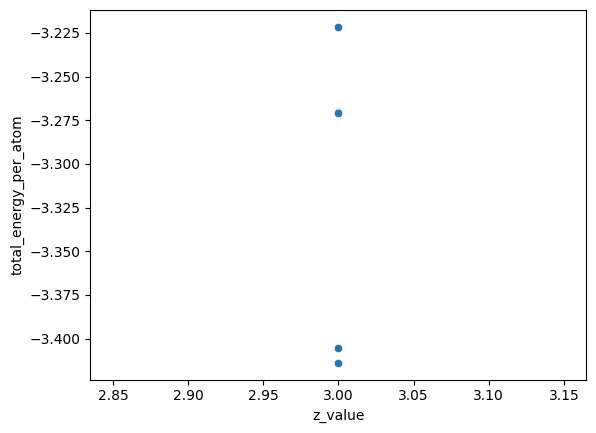

In [16]:
sns.scatterplot(data=df_result,x='z_value',y='total_energy_per_atom')

In [18]:
from pymatgen.analysis import structure_matcher
struturetest = structure_matcher.StructureMatcher()
struturetest.fit(struct1=strc_m3gnet,struct2=strc_mp)

True

In [17]:
strc_m3gnet = SpacegroupAnalyzer(structure=Structure.from_file('temp_files/RbBiTe2_example/z_3_4/BiRbTe2_Bi3Rb3Te6_relax_postitions_and_cell_20240301173605.cif') #, symprec=0.1
                  ).get_conventional_standard_structure()
strc_mp = SpacegroupAnalyzer(structure=Structure.from_file('temp_files/RbBiTe2_example/POSCAR_RbBiTe2_precise') #, symprec=0.1
                  ).get_conventional_standard_structure()